# Overview



# Imports

In [1]:
import functools
import itertools
import multiprocessing
import os.path as op
import queue

import apache_beam as beam
import matplotlib.pyplot as plt
import pandas as pd
from apache_beam.runners.direct.direct_runner import BundleBasedDirectRunner
from apache_beam.runners.interactive.cache_manager import (
    FileBasedCacheManager, ReadCache, WriteCache)
from apache_beam.runners.interactive.interactive_runner import \
    InteractiveRunner
from apache_beam.runners.portability.fn_api_runner import FnApiRunner

try:
    from pathlib import Path
except ImportError:
    from pathlib2 import Path

In [2]:
%matplotlib inline

# Parameters

In [3]:
PROJECT_ID = "strokach-playground"

In [4]:
NOTEBOOK_NAME = "interactive-beam-demo"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)

NOTEBOOK_NAME

interactive-beam-demo

In [5]:
class InteractiveSession(object):

  def __init__(self):
    pass

  def _repr_html_(self):
    return (
        '<p style="padding-left: 1%; padding-right: 1%">'
        '<a href="'
        'https://pantheon.corp.google.com/dataflow/jobsDetail/'
        'locations/us-central1/'
        'jobs/2019-05-30_14_39_33-6947614184630253675'
        '">Dashboard</a>'
        '</p>'
    )


In [6]:
InteractiveSession()

In [7]:
class Foo:
    
    def __enter__(self):
        self._in_context = True
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self._in_context = False
        print("Exiting...!")

In [8]:
foo = Foo()
foo.__enter__()

raise Exception

Exception: 

In [9]:
foo._in_context

True

In [23]:
b"  ¡ ¢ £ ¤ ¥ ¦ § ¨ © ª « ¬ ­ ® ¯ ° ± ² ³ ´ µ ¶ · ¸ ¹ º » ¼ ".replace(b" ", b"")

¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼

In [25]:
import numpy as np

In [28]:
from parameterized import parameterized_class

parameterized_class?

Signature: parameterized_class(attrs, input_values=None)
Docstring:
Parameterizes a test class by setting attributes on the class.

Can be used in two ways:

1) With a list of dictionaries containing attributes to override::

    @parameterized_class([
        { "username": "foo" },
        { "username": "bar", "access_level": 2 },
    ])
    class TestUserAccessLevel(TestCase):
        ...

2) With a tuple of attributes, then a list of tuples of values:

    @parameterized_class(("username", "access_level"), [
        ("foo", 1),
        ("bar", 2)
    ])
    class TestUserAccessLevel(TestCase):
        ...
File:      ~/miniconda3/envs/beam-dev/lib/python2.7/site-packages/parameterized/parameterized.py
Type:      function


In [34]:
from contextlib import closing

In [35]:
with closing(np.random.randn(5,5)) as a:
    print(a)

[[-1.02523120e+00  4.41456844e-01 -6.55800146e-02 -8.38409264e-01
  -4.50373611e-01]
 [-8.95268605e-01  3.40968898e-01 -1.04400535e+00  2.67916415e-01
   7.98220633e-01]
 [ 9.01373326e-01 -2.58044945e-01  4.28317242e-01  6.27783500e-01
  -1.41996093e+00]
 [ 5.45141091e-01 -2.36551663e-01 -1.38269021e+00 -1.04792501e+00
  -1.33748726e-01]
 [ 3.19110706e-01 -7.97200200e-01  3.75175339e-01  1.24083471e-01
   2.42454145e-04]]


AttributeError: 'numpy.ndarray' object has no attribute 'close'

In [8]:
runner = beam.runners.dataflow.DataflowRunner(
    # interactive=True,
    # timeout="30min"
)

In [9]:
options = beam.pipeline.PipelineOptions(
    project=PROJECT_ID,
    job_name=NOTEBOOK_NAME,
    temp_location="gs://strokach/dataflow_temp",
    staging_location="gs://strokach/dataflow_staging",
    sdk_location=op.expanduser(
        "~/workspace/beam/sdks/python/dist/apache-beam-2.14.0.dev0.tar.gz"
    ),
#     timeout=600,
)
options.display_data()

{job_name: interactive-beam-demo,
 project: strokach-playground,
 sdk_location: /usr/local/google/home/strokach/workspace/beam/sdks/python/dist/apache-beam-2.14.0.dev0.tar.gz,
 staging_location: gs://strokach/dataflow_staging,
 temp_location: gs://strokach/dataflow_temp}

In [10]:
cache_manager = FileBasedCacheManager(
    cache_dir="gs://strokach/tmp"
)
# atexit.register(cache_manager.cleanup) <- 

# Setup

In [14]:
runner.start_session(options)

AttributeError: 'DataflowRunner' object has no attribute 'start_session'

# Workflow

### Running a pipeline

In [11]:
with beam.Pipeline() as p:  # display=...
    _ = (
        #
        p
        | "Read" >> beam.io.ReadFromText("gs://strokach/inputs/winterstale")
        | "Write" >> WriteCache(cache_manager, "temp")
    )

#### Notes

- `p.run()` should start the pipeline in the background, even in interactive mode. This makes sense for streaming, or when we want to start reading results as they appear.

- There should be an option to display results while the pipeline is running. However, we should display results when we call `result.wait_until_finish()`, not when we call `p.run()`.

- `result.wait_until_finish()` should not wait for the VM to shut down.

- `WriteCache` should take an extra argument `format`, which allows the use to specify the format that will be used for writing the cache file. It should also be possible to pass additional arguments such as `schema=...`, etc.

### Reading from cache

In [16]:
# The argument should be just "temp", and it should not return "version"
data, _ = cache_manager.read("full", "temp")  

In [35]:
df = pd.DataFrame(data[0], columns=["string"])

df["string_clean"] = df["string"].str.strip()
df["string_length"] = df["string_clean"].str.len()

Text(0,0.5,'Number of strings')

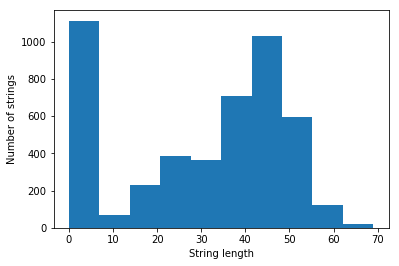

In [39]:
fg, ax = plt.subplots()

_ = ax.hist(df["string_length"])
ax.set_xlabel("String length")
ax.set_ylabel("Number of strings")

#### Notes

- When we read from a `CacheManager`, we should not have to specify "full" or "sample". If the user so desires, they can provide that information in the name that they give to their cache object.

- `CacheManager.read(...)` should not return the cache version by default. It should be assumeed that we are always reading the latest cache object.

- `CacheManager.read(...)` should have a `limit=...` argument.

### Querying cache using Beam SQL, BigQuery, etc.

Until we have a Python frontend for Beam SQL, 

#### Notes

### Processing cached objects using DirectRunner

For simple types of queries that are likely to be limited by I/O, it may be helpful to explore the data using `DirectRunner`. Furthermore, we might want to store the output directly in memory instead of saving it to a file. Both the `BundleBasedDirectRunner` and the `FnApiRunner` run workers inside Python threads, so the results can simply be passed into a `queue.Queue()`. If `DirectRunner` ever switches to using `multiprocessing` ([BEAM-1442](https://issues.apache.org/jira/browse/BEAM-1442)), a more sophisticated way of transfering data between processes may be required. For example, PyTorch creates memory-mapped files, and passes filehandes to those files between processes.

In [38]:
from apache_beam.typehints import typehints


In [73]:
typehints.Union[[str, int, int, str]]

Union[int, str]

In [43]:
isinstance("A", typehints.TypeConstraint)

False

In [ ]:
q = queue.Queue()

In [12]:
def add_to_queue(element, queue):
    queue.put(element)

In [ ]:
cache = Par

## Pipeline

In [98]:
typehints.Union[[int, int, str, None]]

Union[None, int, str]

In [96]:
{
    typehints.Union[int, str, str]: 'a'
}[typehints.Union[int, str, int]]

a

In [122]:
typehints.normalize(b"abc")

abc

In [165]:
from past.builtins import unicode

In [173]:
import pyarrow as pa

In [198]:
pa.array([[1,2,3], [4,5,6], [1.3, 4.5]]).type

ListType(list<item: double>)

In [184]:
x.type

DataType(binary)

In [204]:
pa.int64()

int

In [202]:
  _typehint_to_avro_type = {
      typehints.Union[[int]]: "int",
#       typehints.Union[int, None]: ["int", "null"],
#       typehints.Union[long]: "long",
#       typehints.Union[long, None]: ["long", "null"],
#       typehints.Union[float]: "double",
#       typehints.Union[float, None]: ["double", "null"],
#       typehints.Union[str]: "string",
#       typehints.Union[str, None]: ["string", "null"],
#       typehints.Union[unicode]: "string",
#       typehints.Union[unicode, None]: ["string", "null"],
#       typehints.Union[np.ndarray]: "bytes",
#       typehints.Union[np.ndarray, None]: ["bytes", "null"],
#       typehints.Union[array.array]: "bytes",
#       typehints.Union[array.array, None]: ["bytes", "null"],
#   }

In [168]:
import avro.schema
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter


In [169]:
schema_dict = {"namespace": "example.avro",
 "type": "record",
 "name": "User",
 "fields": [
     {"name": "name", "type": "string"},
     {"name": "favorite_number",  "type": ["int", "null"]},
     {"name": "favorite_color", "type": ["string", "null"]}
 ]
}

In [171]:
import json

In [172]:
avro.schema.parse(json.dumps(schema_dict))

In [206]:
from mock import MagicMock

In [248]:
writer = MagicMock()

In [263]:
writer(a=1, b=2)

<MagicMock name='mock()' id='139704955977872'>

In [264]:
list(writer.call_args)

[(), {a: 1, b: 2}]

In [234]:
cache.writer._sink.write_record.side_effect = Exception

In [235]:
cache.writer._sink.write_record(123)

Exception: 

In [226]:
m.reader.call_count

2

In [227]:
range(0)

[]

In [102]:
from apache_beam.typehints import trivial_inference

In [163]:
trivial_inference.instance_to_type(

unicode

In [149]:
u"±♠Ωℑ".encode('utf-8')

±♠Ωℑ

In [140]:
b"±♠Ωℑ"

±♠Ωℑ

In [109]:
import numpy as np

In [156]:
import array

In [161]:
array1 = array.array('i', [10,20,30,40,50])
array1

array('i', [10, 20, 30, 40, 50])

In [66]:
q = queue.Queue()

with beam.Pipeline(runner=BundleBasedDirectRunner()) as p:
    _ = (
        #
        p
        | "Read" >> ReadCache(cache_manager, "temp")
        | "Remove whitespace" >> beam.Map(lambda element: element.strip("\n\t|"))
        | "Remove empty lines" >> beam.FlatMap(lambda element: [element] if element else [])
        | "Write" >> beam.Map(lambda element: add_to_queue(element, queue=q))
    )

In [67]:
p = beam.Pipeline(runner=BundleBasedDirectRunner())

In [68]:
p | "Read" >> ReadCache(cache_manager, "temp")

<PCollection[Read/Read.None] at 0x7f0fa16c6790>

In [69]:
p | "ass" >> beam.Map(lambda element: element.strip("\n\t|"))

<PCollection[ass.None] at 0x7f0f985a4410>

In [70]:
p | "ass" >> beam.Map(lambda element: element.strip("\n\t|"))

RuntimeError: Transform "ass" does not have a stable unique label. This will prevent updating of pipelines. To apply a transform with a specified label write pvalue | "label" >> transform

In [65]:
p.run()

AttributeError: 'PBegin' object has no attribute 'windowing'

In [ ]:
p.cancel()

In [14]:
data = list(q.queue)

Text(0,0.5,'Number of strings')

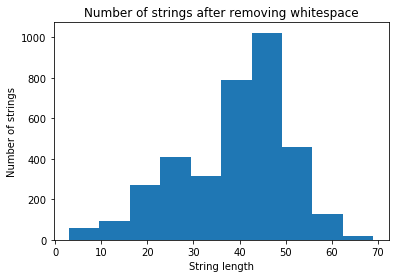

In [15]:
fg, ax = plt.subplots()

_ = ax.hist([len(s) for s in data])
ax.set_title("Number of strings after removing whitespace")
ax.set_xlabel("String length")
ax.set_ylabel("Number of strings")

#### Notes

- It may be useful to have a well-defined class for outputing results to an object in the main process. That way, if the implementation of `DirectRunner` changes, this way of accessing results could remain backwards-compatible.

In [ ]:
reader = beam.io.textio.ReadFromText("gs://strokach/inputs/winterstale")
range_tracker = reader._source.get_range_tracker(None, None)
data = list(reader._source.read(range_tracker))

# Cleanup

In [ ]:
cache_manager.cleanup()

In [ ]:
# runner.__exit__()
# runner.end_session() (?)